In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload() # Upload your kaggle.json file

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair

Saving kaggle.json to kaggle.json
100% 11.6G/11.6G [01:16<00:00, 123MB/s]
100% 11.6G/11.6G [01:16<00:00, 164MB/s]


In [ ]:
from zipfile import ZipFile 
import os

In [ ]:
# Creating A directory which will hold our dataset

data_path = os.path.join(os.getcwd(),'dataset')
os.mkdir(data_path)

print(data_path)

/content/dataset


In [ ]:
## Unzipping [] and extracting the contents to th dataset path

zip_name = data_path + '/anime-sketch-colorization-pair.zip'

with ZipFile(zip_name , 'r') as Zip:
  Zip.extractall()

### Lets Start with building the model architecture

In [ ]:
import os
import tensorflow as tf
import time
import matplotlib.pyplot 
%matplotlib inline

import numpy as np



buffer_size = 1000
batch_size = 4
epochs = 100

img_width = 256
img_height = 256



In [ ]:
path_to_data = os.path.join(os.getcwd(),'data')

In [ ]:
import numpy as np

### Splitting Image into input_image and real_image

In [ ]:

def test(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)
  print(image)
  return image

i = train_dataset.take(1)
i = i.map(test)


Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)


In [ ]:
path_to_data+'/train'

'/content/data/train'

In [ ]:
i = datagen.take(1)
print(i)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def split_image(image_file):
  image = tf.io.read_file(image_file)   
  image = tf.image.decode_png(image)

  image = tf.cast(image,tf.float32)

  w = tf.shape(image)[1]
  w = w//2

  real_image = image[:,:w,:]
  input_image = image[:,w:,:]

  return input_image,real_image

  


  # Shape of the image [num_image,width,height]

### Defining Preprocessing Steps

In [ ]:
def resize(input_image,real_image,height=256,width=256):

  # Resizing IMages to 286*286 half of original input size 512*512
  input_image = tf.image.resize(input_image,size = [height,width])
  real_image = tf.image.resize(real_image,size = [height,width])

  return input_image,real_image

def random_crop(input_image,real_image,height=256,width=256):

  img = tf.stack([input_image,real_image],axis = 0)
  cropped_image = tf.image.random_crop(img,size = (2,height,width,3))

  return cropped_image[0],cropped_image[1]

def normalize(input_image,real_image):
  input_image = input_image/255.0
  real_image = real_image/255.0

  return input_image,real_image


def random_jitter(input_image,real_image,height=256,width=256):
  input_img,real_img = resize(input_image,real_image,height,width)
  input_img,real_img = random_crop(input_img,real_img,height,width)
  

  if tf.random.uniform(()) > 0.5:
    input_img = tf.image.flip_left_right(input_img)
    real_img = tf.image.flip_left_right(real_img)

  return input_img,real_img




In [ ]:
def load_image(image_file):

  input_image,real_image = split_image(image_file)
  
  input_image,real_image = random_jitter(input_image,real_image)
  input_image,real_image = normalize(input_image,real_image)

  return input_image,real_image


In [ ]:
train_dataset = tf.data.Dataset.list_files('/content/Data/train/'+'*.png')

train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size,drop_remainder = True)



In [ ]:
for x,y in train_dataset.take(1):
  print(x.shape)
  break
  

(4, 256, 256, 3)


In [ ]:
def downsample(filters,size,shape,apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0,0.02)

  downsample = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters,size,strides =2,padding= 'same',batch_input_shape = shape,kernel_initializer=initializer,use_bias = False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2)
  ])

  return downsample


def upsample(filters,size,shape,apply_dropout = False):
  initializer = tf.random_normal_initializer(0,0.02)

  upsample = tf.keras.Sequential()
  upsample.add(tf.keras.layers.Conv2DTranspose(filters,size,strides = 2,batch_input_shape = shape,
                                               padding = 'SAME',kernel_initializer=initializer,
                                               use_bias = False))
  upsample.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    upsample.add(tf.keras.layers.Dropout(0.4))

  upsample.add(tf.keras.layers.ReLU())

  return upsample

  
  




In [ ]:
def generator():
  OUTPUT_CHANNELS = 3
  inputs = tf.keras.Input(shape = [256,256,3])

  downstack = [downsample(64,4,(None,256,256,3)),
               downsample(128,4,(None,128,128,64)),
               downsample(256,4,(None,64,64,128)),
               downsample(512,4,(None,32,32,256)),
               downsample(512,4,(None,16,16,512)),
               downsample(512,4,(None,8,8,512)),
               downsample(512,4,(None,4,4,512)),
               downsample(512,4,(None,2,2,512)),]

  up_stack = [
        upsample(512, 4, (None, 1, 1, 512), apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, (None, 8, 8, 1024)),                     # (bs, 16, 16, 1024)
        upsample(256, 4, (None, 16, 16, 1024)),                   # (bs, 32, 32, 512)
        upsample(128, 4, (None, 32, 32, 512)),                    # (bs, 64, 64, 256)
        upsample(64, 4, (None, 64, 64, 256)),                    # (bs, 128, 128, 128)
    ]

  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,strides = 2,padding = 'same',
                                         activation = 'tanh')

  x = inputs

  skips = []

  for down in downstack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up,skip in zip(up_stack,skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x,skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs,outputs = x)

generator = generator()










In [ ]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3328        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

### Buiding Discriminator

In [ ]:
def downs(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  
discriminator = buildDiscriminator()



In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

## Losses

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()

def gen_loss(disc_output,gen_output,target):
  gan_loss = bce(tf.ones_like(disc_output),disc_output)
  l1_loss = tf.reduce_mean(tf.abs(gen_output-target))
  total_gan_loss = gan_loss + l1_loss

  return gan_loss,l1_loss,total_gan_loss

def disc_loss(disc_real_output,disc_gen_output):
  disc_real_loss = bce(tf.ones_like(disc_real_output),disc_real_output)

  disc_gen_loss = bce(tf.zeros_like(disc_gen_output),disc_gen_output)

  total_disc_loss = disc_real_loss + disc_gen_loss

  return total_disc_loss



In [ ]:
## Defining OPtimizers

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './Sketch2Color_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)



In [ ]:
## PLot utility func
from  IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

def plot_multiple_images(images,n_cols = None):
  display.clear_output(wait = False)

  n_cols = n_cols or len(images)
  n_rows = (len(images)-1) // n_cols +1

  if images.shape[-1] == 1:
    images = np.squeeze(images,axis = -1)

  plt.figure(figsize = (n_cols,n_rows))

  for index,image in enumerate(images):
    plt.subplot(n_rows,n_cols,index+1)
    plt.imshow(image)
    plt.axis('off')


Logging Losses

In [ ]:
import datetime

log_dir = 'Sketch2Color_logs/'

summary_writer = tf.summary.create_file_writer(log_dir + '/fit' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

#### Train Step


In [ ]:
@tf.function

def train_on_batch(image):
  sketch_image,colored_image = image

  with tf.GradientTape() as gen_tape ,tf.GradientTape() as disc_tape:

    gen_output = generator(sketch_image , training = True)

    disc_real_output = discriminator([sketch_image,colored_image],training = True)
    disc_gen_output = discriminator([sketch_image,gen_output],training = True)

    discrim_loss = disc_loss(disc_real_output,disc_gen_output)
    gan_loss,l1_loss,total_gan_loss = gen_loss(disc_gen_output,gen_output,colored_image)

  gen_gradient = gen_tape.gradient(total_gan_loss,generator.trainable_variables)
  disc_gradient = disc_tape.gradient(discrim_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradient,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradient,discriminator.trainable_variables))

  return total_gan_loss,discrim_loss


  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss' , total_gan_loss,step = epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', discrim_loss, step=epoch)



In [ ]:
!pip install tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def train(train_dataset,epochs=2):
  #epochs = 2
  gen_loss = []
  disc_loss = []
  for epoch in range(epochs):

    start = time.time()
    batch_gen_loss,batch_disc_loss = [],[]
    for index,(sketch,real) in enumerate(train_dataset):


      gen_losses,disc_losses = train_on_batch((sketch,real))
      batch_gen_loss.append(gen_losses)
      batch_disc_loss.append(disc_losses)

    if (epoch+1)% 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    gen_loss.append(np.mean(batch_gen_loss))
    disc_loss.append(np.mean(batch_disc_loss))
    print('Epoch No {}: gen loss {} , disc loss {}'.format(epoch+1,np.mean(batch_gen_loss),np.mean(batch_disc_loss)))
    print('Time taken for Epoch : {} sec'.format(time.time()-start))
    print('......')

  checkpoint.save(file_prefix = checkpoint_prefix)












Lets Begin the Training Process

In [ ]:
train(train_dataset,epochs = 100)

Epoch No 1: gen loss 14.603096008300781 , disc loss 5.144351005554199
Time taken for Epoch : 620.0019183158875 sec
......
Epoch No 2: gen loss 14.697676658630371 , disc loss 8.860431671142578
Time taken for Epoch : 613.5461299419403 sec
......
Epoch No 3: gen loss 12.313529968261719 , disc loss 11.369258880615234
Time taken for Epoch : 613.6355979442596 sec
......
Epoch No 4: gen loss 15.339865684509277 , disc loss 7.691336154937744
Time taken for Epoch : 613.7346980571747 sec
......


In [ ]:

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

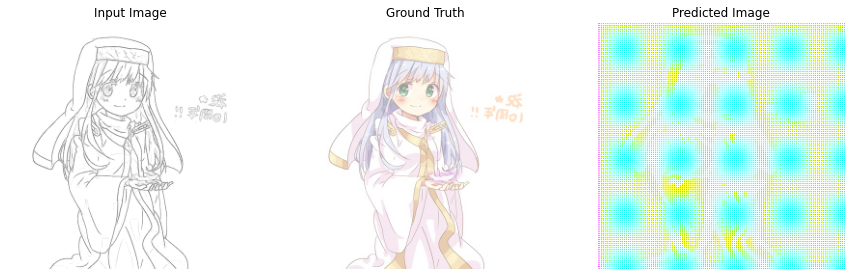

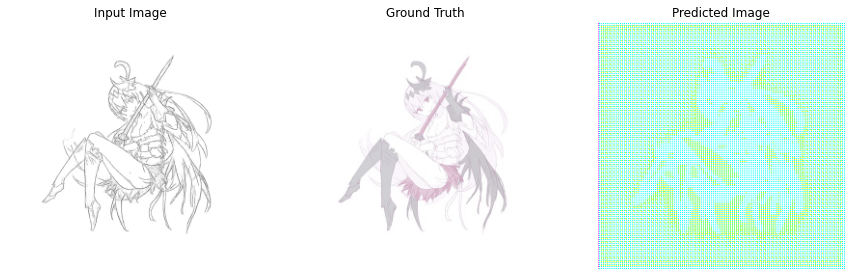

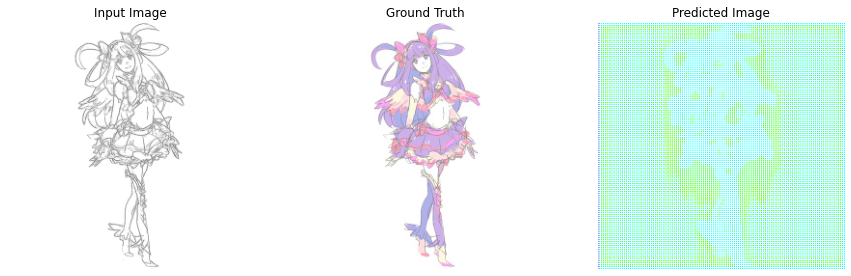

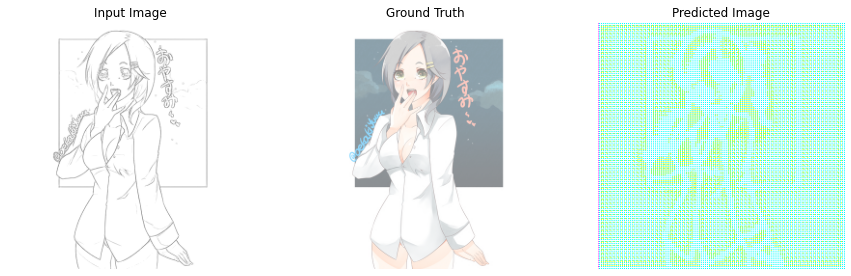

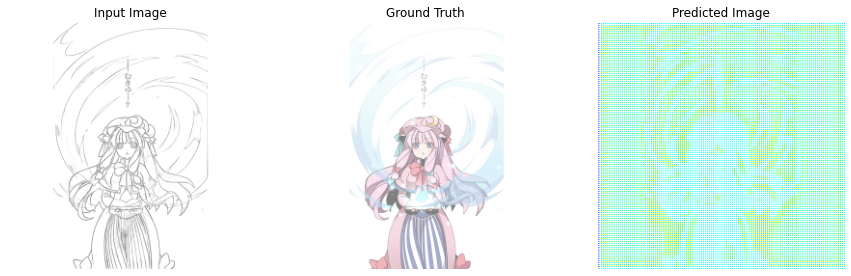

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
for example_input, example_target in train_dataset.take(5):
    generate_images(generator, example_input, example_target)

In [ ]:
df = tf.data.Dataset.list_files('/content/IMG20220807004115.png')
df = df.map(load_image)